<a href="https://colab.research.google.com/github/ambgeo/geoquantificacao/blob/main/01%20-%20Fundamentos_GEE_simples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Fundamentos do Google Earth Engine (GEE) — Notebook Simples

Este notebook cobre, de forma direta, os fundamentos solicitados:
* 1) **O que é o GEE**
* 2) **Autenticação**
* 3) **Abrir um mapa no geemap**
* 4) **Definir a ROI a partir de um asset em `users/...`**
* 5) **Abrir o dado do NASADEM**
* 6) **Extrair média, mínimo e máximo para a ROI**
* 7) **Plotar um gráfico usando `ee_to_df`**
* 8) **Exportar a cena**

## 1) O que é o GEE
O **Google Earth Engine (GEE)** é uma plataforma de computação em nuvem para análise de dados geoespaciais em escala.
Ela reúne um grande repositório de dados (imagens de satélite, modelos, vetores) e oferece uma API para processar tudo **no servidor**, sem precisar baixar dados localmente.

## 2) Autenticação
Execute a célula abaixo. Se for a primeira vez na sessão, será solicitado login.

> Observação: o `project` abaixo está definido como `ee-scriptsambgeo` conforme solicitado. Ajuste se necessário.

In [1]:
import ee

# 1) Autenticar (rode uma vez por sessão):
try:
    ee.Authenticate()  # Pode abrir uma janela para login; copie e cole o token.
except Exception as e:
    print('Se já autenticou anteriormente, você pode ignorar este aviso:', e)

# 2) Inicializar a sessão do Earth Engine
ee.Initialize(project='ee-scriptsambgeo')
print('GEE inicializado com sucesso!')

GEE inicializado com sucesso!


## 3) Abrir um mapa no geemap
Crie um mapa interativo. Se preferir, ajuste o centro/zoom.

In [2]:
# Se necessário: !pip install -q geemap folium ipyleaflet
import geemap

Map = geemap.Map(center=[-15, -55], zoom=4)
Map.addLayerControl()
Map

Map(center=[-15, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

## 4) Definir a ROI desenhando no mapa

- Use a ferramenta **Draw** do `geemap` (ícone de lápis no canto superior esquerdo do mapa) para desenhar um **polígono** delimitando sua área de interesse (ROI).
- Após desenhar, execute a célula abaixo para capturar a geometria e usá-la nas análises.
- A ROI será definida diretamente a partir das coordenadas desenhadas no mapa.

> Dica: você pode apagar ou redesenhar a ROI no mapa a qualquer momento antes de executar a célula.


In [3]:
roi = Map.user_roi
Map.centerObject(roi, 9)
Map.addLayer(roi, {"color": "red"}, "ROI")
Map

Map(bottom=284164.0, center=[-14.757300148990991, -48.85484299999604], controls=(WidgetControl(options=['posit…

## 5) Abrir dado do NASADEM
Usaremos o dataset **`NASA/NASADEM_HGT/001`** e a banda `elevation` (aprox. 30 m).

In [5]:
nasadem = ee.Image('NASA/NASADEM_HGT/001').select('elevation')
nasadem_roi = nasadem.clip(roi) if roi is not None else nasadem

viz = {"min": 0, "max": 3000}
Map.addLayer(nasadem_roi, viz, 'NASADEM — Elevação')
Map

Map(bottom=568145.0, center=[-14.787187715637442, -48.8620863819186], controls=(WidgetControl(options=['positi…

## 6) Estatísticas (média, mínimo e máximo) na ROI
Calculamos estatísticas simples de elevação dentro da ROI.

In [6]:
if roi is None:
    raise ValueError('Defina a ROI antes de prosseguir (asset users/... ou desenho no mapa).')

stats = nasadem.reduceRegion(
    reducer=ee.Reducer.mean().combine(ee.Reducer.minMax(), sharedInputs=True),
    geometry=roi,
    scale=30,
    maxPixels=1e12
).getInfo()
print('Estatísticas de Elevação (m):', stats)

Estatísticas de Elevação (m): {'elevation_max': 802, 'elevation_mean': 565.4854114609386, 'elevation_min': 489}


## 7) Gráfico com `ee_to_df`
Amostramos pontos dentro da ROI, convertemos para **DataFrame** com `geemap.ee_to_df()` e plotamos um histograma simples de elevação.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Amostra de pixels (reduza numPixels para ROIs muito grandes)
samples_fc = nasadem.sample(region=roi, scale=30, numPixels=2000, geometries=True, seed=42)
df = geemap.ee_to_df(samples_fc)

df.head()

,elevation
0,653
1,674
2,534
3,553
4,558


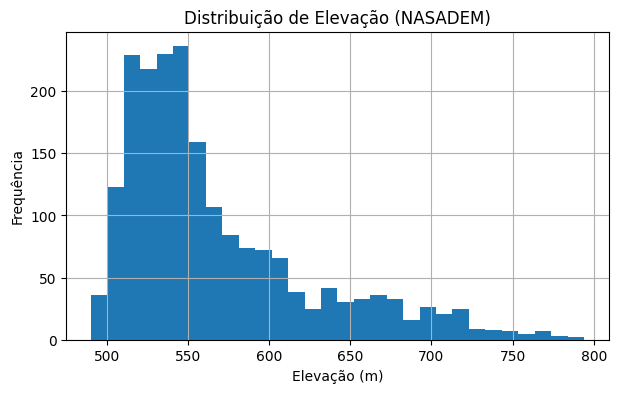

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(df['elevation'].dropna(), bins=30)
plt.title('Distribuição de Elevação (NASADEM)')
plt.xlabel('Elevação (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

## 8) Exportar a cena
Você pode exportar a imagem recortada pela ROI como **GeoTIFF**.

### Opção A) Exportar para Google Drive (servidor do GEE)
Use `ee.batch.Export.image.toDrive` e acompanhe o status na aba **Tasks** do Code Editor.

In [11]:
task = ee.batch.Export.image.toDrive(
    image=nasadem_roi,
    description='NASADEM_elevacao_ROI',
    fileNamePrefix='NASADEM_elevacao_ROI',
    region=roi.getInfo()['coordinates'],
    folder='Geoquanti',
    scale=30,
    maxPixels=1e13
)
task.start()
print('Exportação iniciada para o Google Drive. Verifique a aba **Tasks** no EE Code Editor.')

Exportação iniciada para o Google Drive. Verifique a aba **Tasks** no EE Code Editor.


In [13]:
##status
task.status()

{'state': 'COMPLETED',
 'description': 'NASADEM_elevacao_ROI',
 'priority': 100,
 'creation_timestamp_ms': 1755207910554,
 'update_timestamp_ms': 1755207957139,
 'start_timestamp_ms': 1755207922411,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1_RIGRqMS_L3svVUh2ObkY-Ed2TGOs-Z5'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 0.11689992994070053,
 'id': 'MQJULP2S3Z6YYEUVAWARVHIE',
 'name': 'projects/ee-scriptsambgeo/operations/MQJULP2S3Z6YYEUVAWARVHIE'}

### Opção B) Exportar localmente com `geemap`
Baixa o GeoTIFF diretamente para a máquina onde o notebook está rodando.

In [15]:
import geemap
out_tif = 'nasadem_elevacao_roi.tif'
geemap.ee_export_image(
    nasadem_roi,
    filename=out_tif,
    scale=30,
    region=roi,
    file_per_band=False
)
print('Arquivo salvo em:', out_tif)

Generating URL ...
Please wait ...
Data downloaded to /content/nasadem_elevacao_roi.tif
Arquivo salvo em: nasadem_elevacao_roi.tif


## 9) Plot rasterio

In [16]:
!pip -q install rasterio spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 18.1 MB/s eta 0:00:00


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


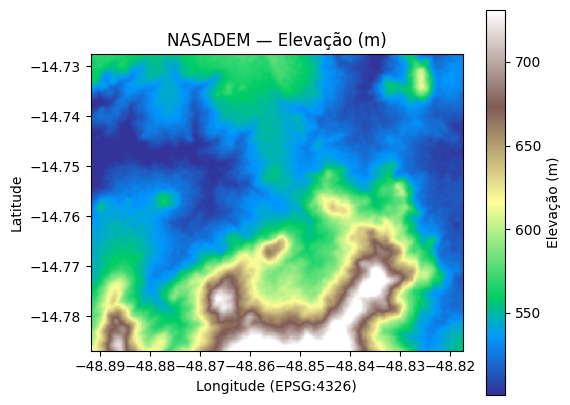

In [24]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

with rio.open('/content/nasadem_elevacao_roi.tif') as src:
    elev = src.read(1, masked=True)
    left, bottom, right, top = src.bounds  # coordenadas reais do raster

# stretch robusto para contraste
vmin, vmax = np.nanpercentile(elev.compressed(), (2, 98))

plt.figure(figsize=(6,5))
plt.imshow(elev, cmap='terrain', vmin=vmin, vmax=vmax,
           extent=[left, right, bottom, top], origin='upper')
plt.colorbar(label='Elevação (m)')
plt.xlabel(f'Longitude ({src.crs.to_string()})')
plt.ylabel('Latitude')
plt.title('NASADEM — Elevação (m)')
plt.show()
